<a href="https://colab.research.google.com/github/ZacharyFry1/DD-Science-Cohort15/blob/main/Project_2_Version7_RMSPE_18_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Housing Prices

## Problem Definition


The goal of this project is to design a linear regression model with the smallest amount of RMS percentage error that accurately predicts the sale price of the house. The sale price is the target, making this is a supervised problem. The regression model will be unidimensional because we only care about how different features affect the home's sale price.

## Data Collection/Sources


### Imports

In [367]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Reading In Data

In [368]:
url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv'

In [369]:
housing_df = pd.read_csv(url)
housing_df

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,903231070,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
2633,906201021,80,RL,74.0,10778,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,162000
2634,533253070,120,RL,61.0,3782,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,211500
2635,527376100,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,165000


## Data Cleaning


### Dropping Null Values

In [370]:
housing_df.isnull().sum().sum()

14208

In [371]:
null_sums = housing_df.isna().sum()
null_sums[null_sums > 0]

,0
Lot Frontage,449
Alley,2457
Mas Vnr Type,1607
Mas Vnr Area,23
Bsmt Qual,73
Bsmt Cond,73
Bsmt Exposure,76
BsmtFin Type 1,73
BsmtFin SF 1,1
BsmtFin Type 2,74


Creating a Threshold For Null Values. All columns above this about will be dropped.

In [372]:
housing_df_clean = housing_df.copy()

In [373]:
# Threshold for non-nulls.
threshold = 10  # Set your threshold
null_percentages = housing_df_clean.isnull().sum() / len(housing_df_clean) * 100
columns_to_keep = null_percentages[null_percentages <= threshold].index
housing_df_clean = housing_df_clean[columns_to_keep]

In [374]:
housing_df_clean = housing_df_clean.dropna()

In [375]:
housing_df_clean = housing_df_clean.drop('PID', axis = 1)

In [376]:
housing_df_clean.isna().sum().sum()

0

In [377]:
housing_df_clean.shape

(2404, 73)

### Creating a DataFrame For the Categorical Columns

In [378]:
housing_df_categorical_cols = housing_df_clean.select_dtypes(include=['object']).columns
housing_df_categorical_cols

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type', 'Sale Condition'],
      dtype='object')

### Creating Numerical DataFrame

In [379]:
housing_df_numerical = housing_df_clean.select_dtypes(exclude=['object'])

In [380]:
housing_df_numerical

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,20,14299,4,3,1964,1964,0.0,513.0,144.0,348.0,...,0,0,0,0,0,0,0,7,2007,115400
2,50,9000,6,6,1937,1950,0.0,0.0,0.0,780.0,...,0,162,0,0,126,0,0,12,2007,141000
3,60,7379,8,5,2000,2000,0.0,484.0,0.0,491.0,...,280,184,0,0,0,0,0,4,2010,254000
4,70,7200,7,9,1936,2007,0.0,350.0,210.0,0.0,...,256,0,0,0,0,0,0,4,2009,155000
5,20,8521,5,5,1967,1967,0.0,842.0,0.0,70.0,...,0,0,0,0,0,0,0,5,2010,125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,6240,6,6,1934,1950,0.0,0.0,0.0,816.0,...,112,0,0,0,0,0,400,9,2006,114500
2633,80,10778,7,6,1990,1991,0.0,460.0,286.0,308.0,...,114,36,0,0,0,0,0,7,2009,162000
2634,120,3782,8,5,1981,1981,0.0,960.0,0.0,266.0,...,133,78,0,0,0,0,0,9,2009,211500
2635,20,10140,6,5,1974,1974,174.0,0.0,0.0,1064.0,...,0,0,0,0,0,0,0,8,2009,165000


### Checking The Target Column

In [381]:
housing_df_clean['SalePrice'].value_counts()
housing_df_clean['SalePrice']

,SalePrice
0,115400
2,141000
3,254000
4,155000
5,125000
...,...
2632,114500
2633,162000
2634,211500
2635,165000


## Exploratory Data Analysis


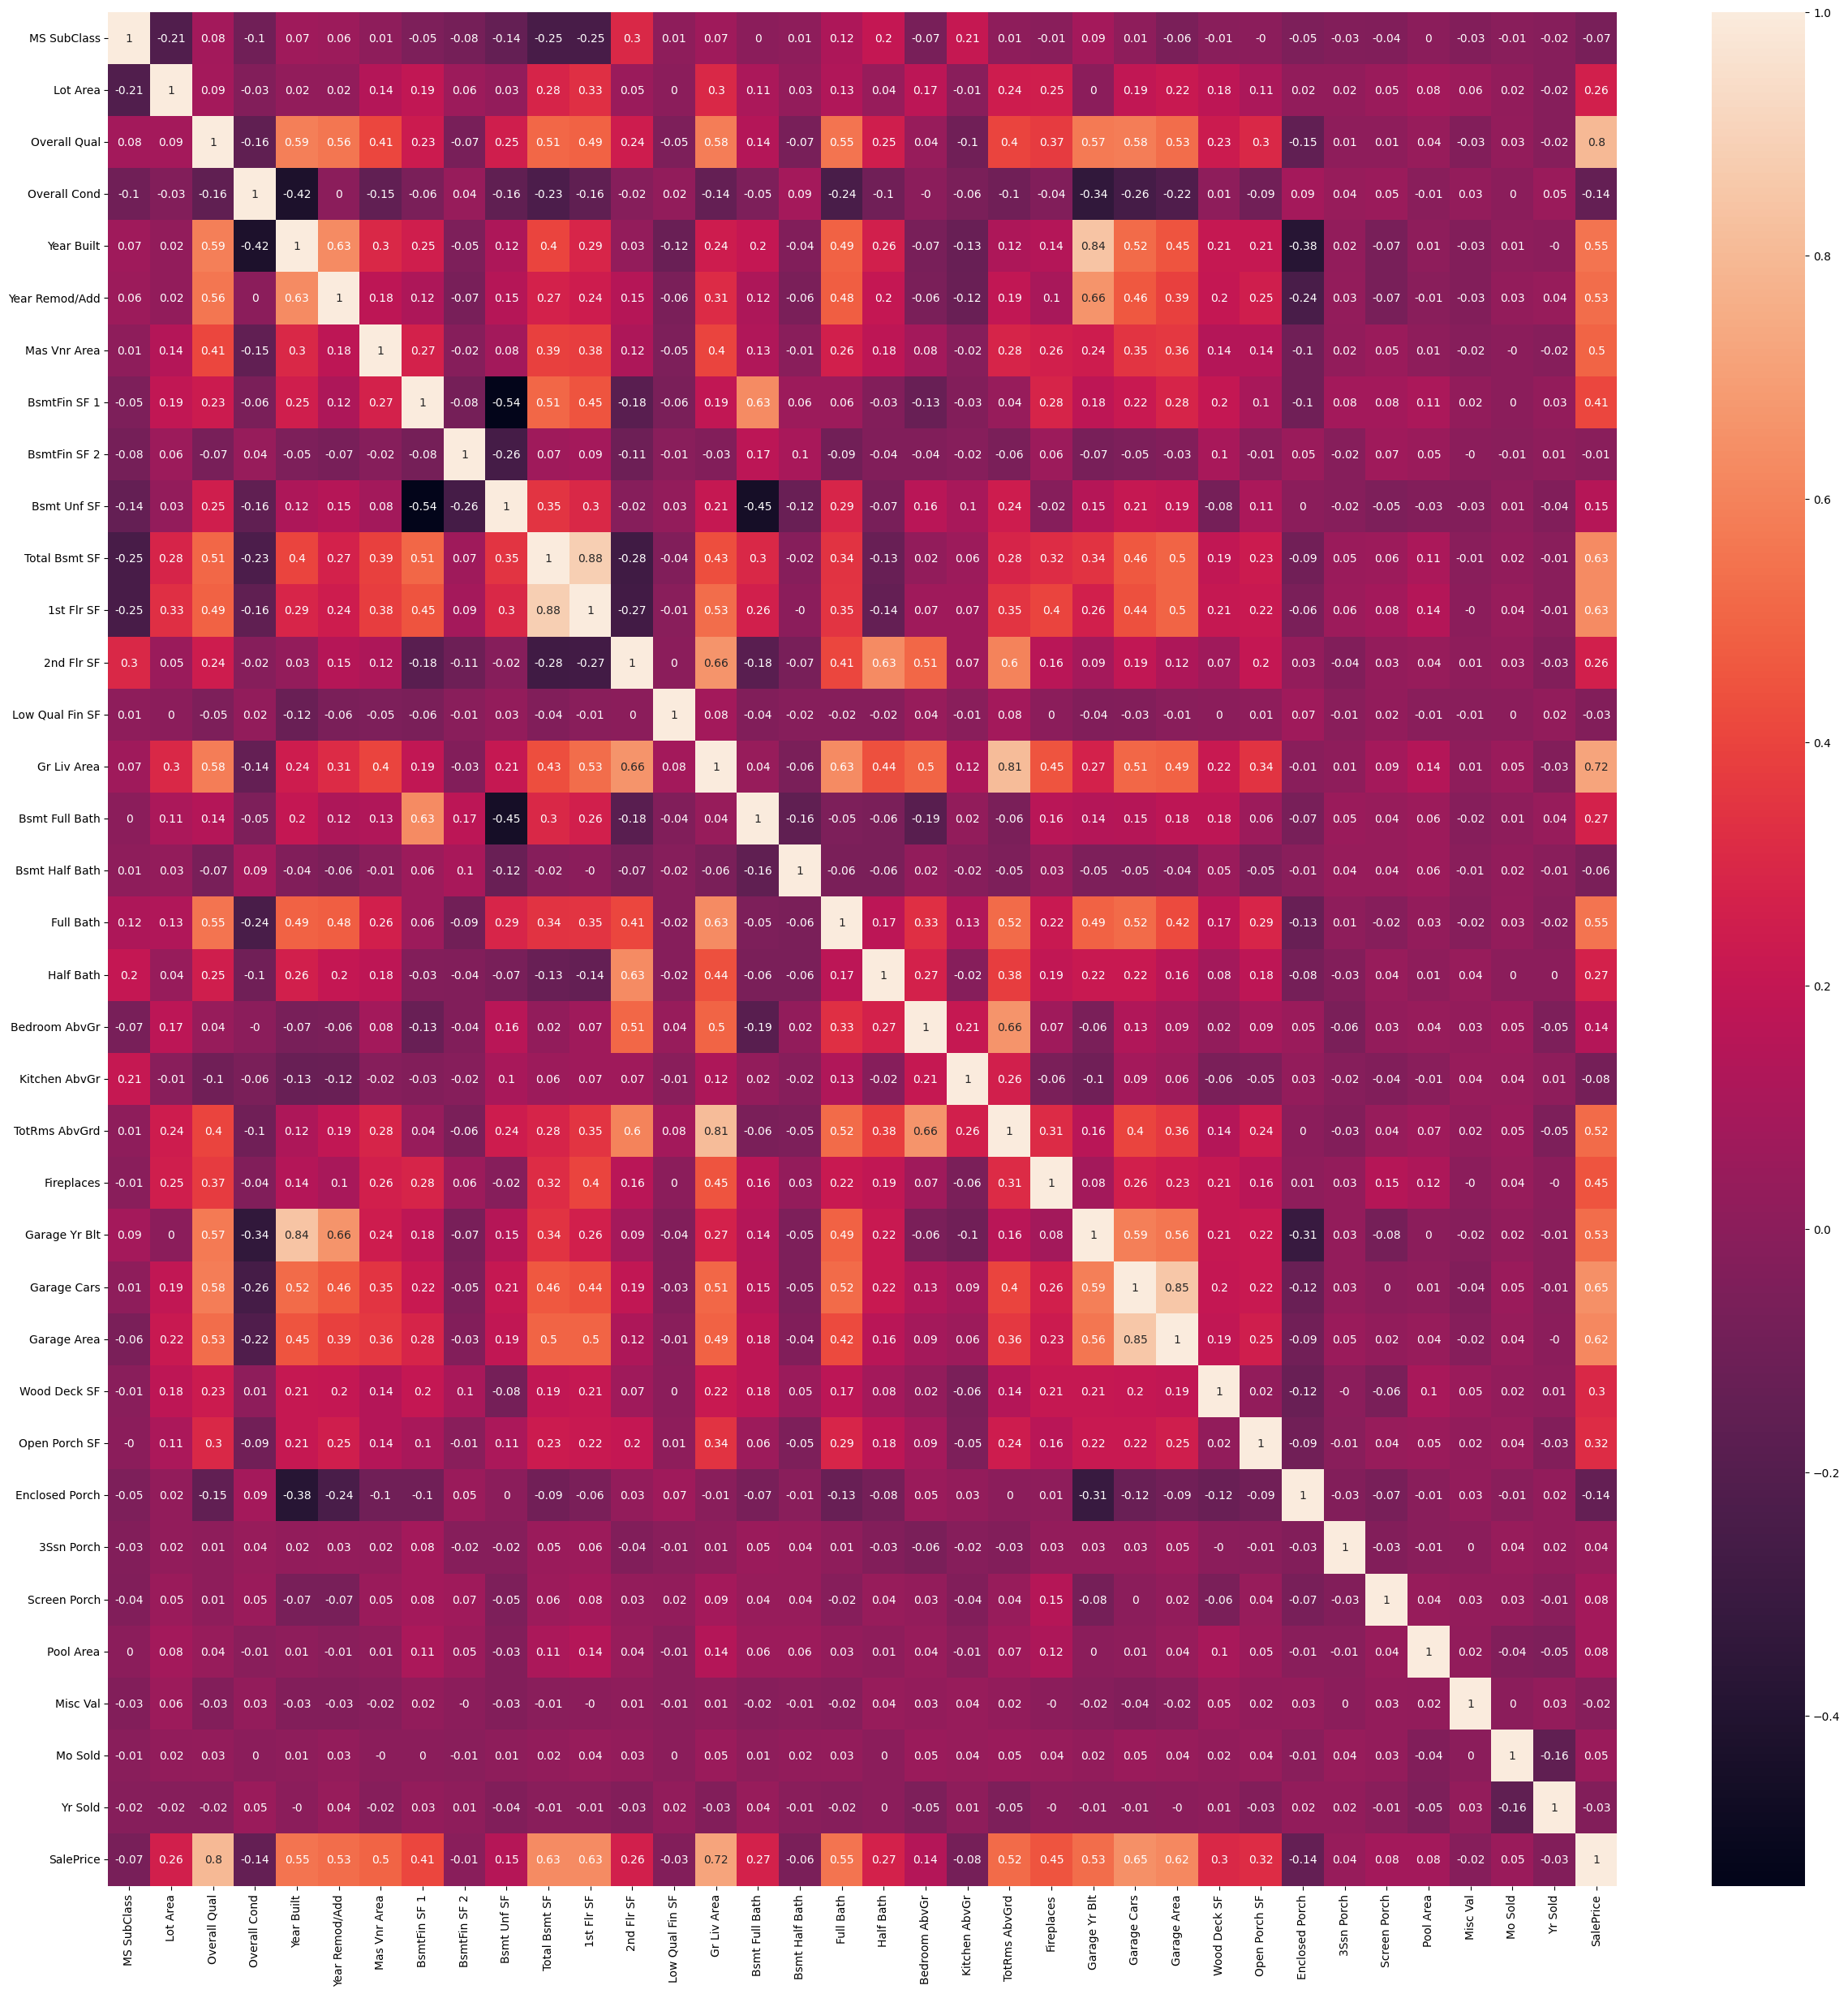

In [382]:
# Let's take a look at a correlation plot
plt.figure(figsize=(30,30))
correlation_matrix = housing_df_numerical.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True) ;

In [383]:
corrs = housing_df_numerical.corr().round(2).unstack().abs()
corrs = corrs[corrs < 1]
corrs.sort_values(ascending = False)[::2]

Total Bsmt SF  1st Flr SF       0.88
Garage Cars    Garage Area      0.85
Garage Yr Blt  Year Built       0.84
TotRms AbvGrd  Gr Liv Area      0.81
Overall Qual   SalePrice        0.80
                                ... 
Lot Area       Garage Yr Blt    0.00
Garage Yr Blt  Lot Area         0.00
               Pool Area        0.00
Garage Cars    Screen Porch     0.00
Garage Area    Yr Sold          0.00
Length: 630, dtype: float64

## Processing


### One Hot Encoding

In [384]:
housing_df_categorical_cols = housing_df_clean.select_dtypes(include=['object']).columns

In [385]:
housing_df_encoded = pd.get_dummies(housing_df_categorical_cols)

In [386]:
housing_df_encoded.isna().sum().sum()

0

### Combining the Numerical and Encoded DataFrames

In [387]:
combined_housing_df =  pd.concat([housing_df_numerical, housing_df_encoded], axis = 1)

In [388]:
combined_housing_df.shape

(2406, 73)

Fill the NA's with the means of each column.

In [389]:
column_means = combined_housing_df.mean()
combined_housing_df = combined_housing_df.fillna(column_means)

In [390]:
# First we will break up our data into training and testing sets
X = combined_housing_df.drop('SalePrice', axis = 1).copy()
X = sm.add_constant(X)
y = combined_housing_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [391]:
def rmspe(y_test, y_pred):
  '''
  This function takes y_test and y_pred and calculates the RMSPE'''
  return np.sqrt(np.mean(np.square((y_test - y_pred) / y_test))) * 100

In [392]:
# Fit a linear model using Sklearn
model = LinearRegression()
combined_housing_df_fit_SK = model.fit(X_train, y_train)

(combined_housing_df_fit_SK.intercept_, combined_housing_df_fit_SK.coef_ )

(1079812.8967865293,
 array([-2.78169712e-09, -1.44495275e+02,  2.20485264e-01,  1.85328625e+04,
         4.81834700e+03,  3.34203266e+02,  2.05314105e+02,  2.86652749e+01,
         1.14703573e+01,  5.42968609e+00, -3.52887695e-01,  1.65471552e+01,
         1.44124663e+01,  1.70982374e+01,  1.65404455e+00,  3.31647478e+01,
         7.94092643e+03,  1.35362355e+03, -1.34166287e+03, -3.22829957e+03,
        -7.29013226e+03, -2.49393306e+04,  4.87290268e+03,  2.90466964e+03,
        -1.13350275e+01,  1.18549266e+04,  8.63308576e+00,  2.02335172e+01,
        -7.61935408e+00,  1.64861310e+01,  2.05528426e+01,  4.68232685e+01,
        -2.60494495e+01, -4.77152470e-01,  2.80272103e+01, -1.09126710e+03,
        -1.00246582e+04, -2.32950245e+04,  8.70768287e+03,  3.59018119e+02,
         3.59018119e+02, -1.67225819e+04, -1.78535805e+04, -6.97951600e+03,
         3.59018119e+02, -2.36707492e+04,  7.02179585e+04,  5.50213208e+04,
         3.59018119e+02,  3.59018119e+02, -2.20824129e+04,  4.51277

### Cross Validation

In [393]:
# Cross Validation of the combined data

n = 200
results = np.zeros(n)
for idx in range(n):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results[idx] = rmspe(y_test,y_pred)
print(f"CV RMSPE: {results.mean().round(2)}%")
print(f"Number of Predictors: {len(X.columns)}")

CV RMSPE: 18.4%
Number of Predictors: 73


In [394]:
y_pred = combined_housing_df_fit_SK.predict(X_test)
list(zip(y_test, y_pred))[:5]

[(385000.0, 386625.76568159997),
 (125500.0, 96203.62081062328),
 (355000.0, 282992.0541900692),
 (145000.0, 153370.01736449124),
 (117000.0, 154935.67962804623)]

### Filtering Data/ Feature Selection


**QQ PLOT**

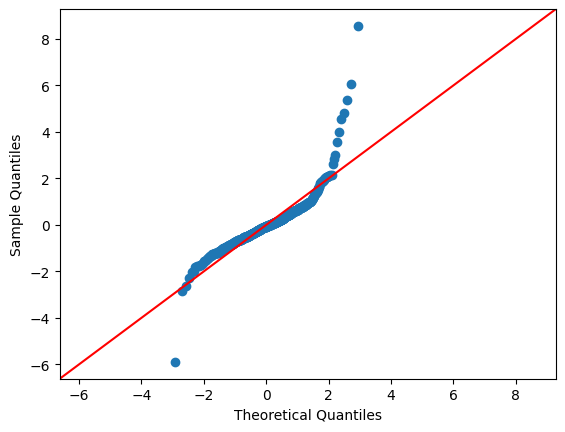

In [395]:
res = y_test - y_pred
sm.qqplot(res, fit=True, line="45") ;

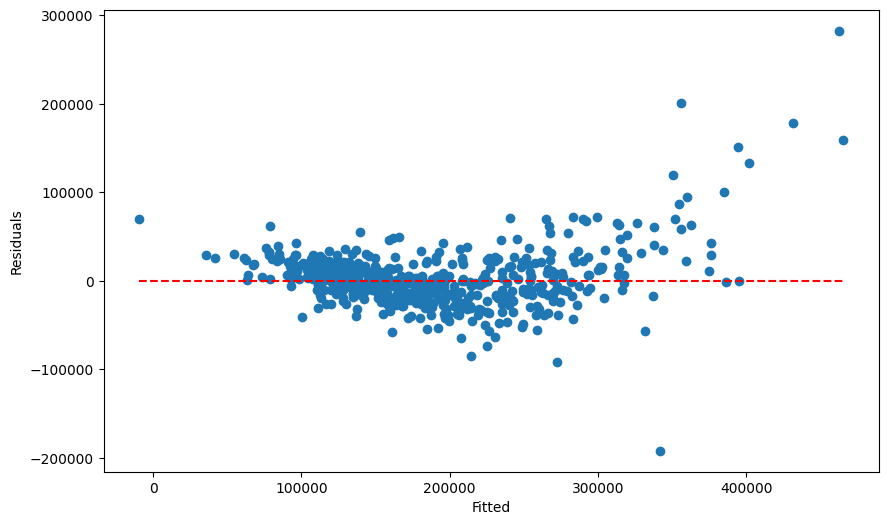

In [396]:
# Residuals vs Fitted (Predicted) Values - Constant variance
plt.figure(figsize = (10,6))
plt.scatter(y_pred, res)
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.hlines(0, min(y_pred), max(y_pred), colors = 'red', linestyles = 'dashed') ;

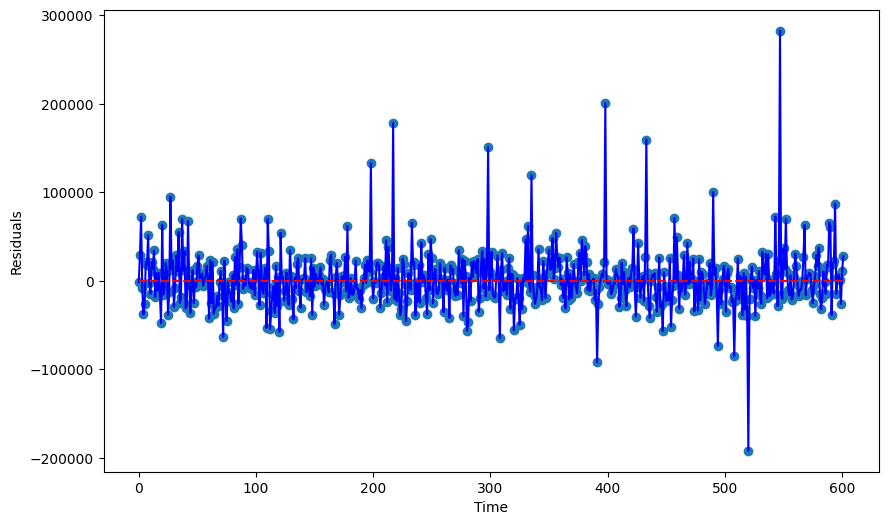

In [397]:
# Residuals vs Time - indepedence
plt.figure(figsize = (10,6))
plt.scatter(range(len(res)), res)
plt.plot(range(len(res)), res, 'b')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.hlines(0, min(range(len(res))), max(range(len(res))), colors = 'red', linestyles = 'dashed') ;

### SUMMARY


Dropped all null values. One hot encoded the categorical columns. Dropped columns where the non-null values where above 15% of the data. Replaced all 0 values with the mean of each column. RSMPE value of 14.24.